<p>The following notebook provides a measurement of the risk and returns of my personal portflio. The following metrics are created using pyFolio package. The pyFolio package expects an array of daily returns. So the following notebook computes the daily returns from the tradebook.<br />
&nbsp;</p>


In [2]:
from __future__ import print_function

#import urllib2
import os
from datetime import timedelta

import matplotlib.pyplot as plt
% run 'MoneyControl.ipynb'
import functools
import pandas as pd

pd.core.common.is_list_like = pd.api.types.is_list_like
import pyfolio as pf
import matplotlib
import matplotlib.dates as mdates

matplotlib.use('TkAgg')
% matplotlib inline

# silence warnings
import warnings

warnings.filterwarnings('ignore')


In [3]:
parser = lambda date: pd.datetime.strptime(date, '%d/%m/%y')
trades = pd.read_csv('data/Tradebook.csv',delimiter=',',encoding='utf-8', parse_dates=True, date_parser=parser, header=0)
trades.date = pd.to_datetime(trades.date, format = '%d/%m/%y')
trades = trades.set_index(['scrip', 'date'])
trades['type'] = ((trades['type'] == 'Buy').astype(int)).replace(0, -1)
trades.sort_index(inplace=True)
scrips = trades.index.levels[0]

In [4]:
def getAdjustmentFactor(scrip):
    df = adjustmentFactor(scrip)
    df['scrip'] = scrip
    df = df.reset_index()
    df = df.set_index(['scrip', 'date'])
    return df

In [5]:
dfs = map(lambda scrip: getAdjustmentFactor(scrip), scrips)
adjFactor = pd.concat(dfs)
adjFactor = np.ceil(adjFactor)
trades['adjPrice'] = (trades['price'] / adjFactor['factor']).dropna()
trades['adjQuantity'] = (((trades['quantity'] * adjFactor['factor']).dropna()).round() * trades['type']) 

In [6]:
def wavg(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [7]:
def totalQty(group, column):
    return group[column].sum()

In [8]:
def aggFunc(group, avg_name, weight_name):
    d = {}
    d['adjPrice'] = wavg(group, avg_name, weight_name)
    d['adjQuantity'] = totalQty(group, weight_name)
    return pd.Series(d, index=['adjPrice', 'adjQuantity'])

In [9]:
ledger = trades.groupby(['scrip', 'date','type']).apply(aggFunc, "adjPrice", "adjQuantity")

In [9]:
#ledger

In [10]:
def getWeightMatrix(trades):
    trades = trades.reset_index()
    scrips = trades.scrip.unique()
    weights = []
    for scrip in scrips:
        weight = trades[trades['scrip'] == scrip][['adjQuantity', 'date']]
        weight = weight.rename(columns={'adjQuantity' : scrip})
        weight = weight.set_index('date')
        weight = weight[~weight.index.duplicated()]
        weights.append(weight)
    weightMatrix = pd.concat(weights, axis=1).sort_index().fillna(0)
    return weightMatrix

In [11]:
def getPriceMatrix(trades):
    trades = trades.reset_index()
    scrips = trades.scrip.unique()
    prices = []
    for scrip in scrips:
        price = trades[trades['scrip'] == scrip][['adjPrice', 'date']]
        price = price.rename(columns={'adjPrice' : scrip})
        price = price.set_index('date')
        price = price[~price.index.duplicated()]
        prices.append(price)
    priceMatrix = pd.concat(prices, axis=1).sort_index().fillna(0)
    return priceMatrix    

In [12]:
parser = lambda date: pd.datetime.strptime(date, '%Y-%m-%d')
def getDailyAdjClose(symbol):
    print("getDailyAdjClose for " + symbol)
    if(os.path.exists("data/" + 'NSE:' + symbol + ".csv") == True):
        df = pd.read_csv("data/" + 'NSE:' + symbol + ".csv", parse_dates=True, date_parser=parser, header=0)
        df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
        df = df.set_index(['Date'])
        returns = df[["AdjClose"]]
        returns = returns.rename(index=str, columns={"AdjClose": symbol}).loc[(returns != 0).any(1)]
        returns = returns[~returns.index.duplicated()]
        returns.index = pd.to_datetime(returns.index)        
        return returns
    else:
        return pd.DataFrame()

def getDailyAdjClose4All(stocks):
    return functools.reduce(lambda left, right: pd.concat([left, right], axis=1), [getDailyAdjClose(stock) for stock in stocks])

In [13]:
weightMatrix = getWeightMatrix(ledger).cumsum()
dateRange = pd.date_range('2009-04-01', '2018-03-31')
weightMatrix = weightMatrix.reindex(dateRange, method='ffill').fillna(0)

In [14]:
priceMatrix = getPriceMatrix(trades)['2009-04-01':'2018-03-31']

In [15]:
nWeightMatrix = weightMatrix.divide(weightMatrix.sum(axis=1), axis=0)

In [16]:
adjCloseMatrix = getDailyAdjClose4All(trades.index.levels[0])['2009-04-01':'2018-03-31']

getDailyAdjClose for APOLLOHOSP
getDailyAdjClose for ASIANPAINT
getDailyAdjClose for AVANTIFEED
getDailyAdjClose for AXISBANK
getDailyAdjClose for AXISCADES
getDailyAdjClose for BAJAJFINSV
getDailyAdjClose for BAJFINANCE
getDailyAdjClose for BALAJITELE
getDailyAdjClose for BALKRISIND
getDailyAdjClose for BANKRAJAS
getDailyAdjClose for BATAINDIA
getDailyAdjClose for BERGEPAINT
getDailyAdjClose for CAIRN
getDailyAdjClose for CANBK
getDailyAdjClose for CANFINHOME
getDailyAdjClose for CEATLTD
getDailyAdjClose for CENTEXT
getDailyAdjClose for CGPOWER
getDailyAdjClose for CLUTCHAUTO
getDailyAdjClose for CUB
getDailyAdjClose for DCBBANK
getDailyAdjClose for DHANBANK
getDailyAdjClose for DIVISLAB
getDailyAdjClose for EDELWEISS
getDailyAdjClose for EICHERMOT
getDailyAdjClose for EMPEESUG
getDailyAdjClose for ENGINERSIN
getDailyAdjClose for ESCORTS
getDailyAdjClose for FCSSOFT
getDailyAdjClose for FEDERALBNK
getDailyAdjClose for FINCABLES
getDailyAdjClose for FORTIS
getDailyAdjClose for GICHSGFI

In [17]:
adjCloseMatrix = adjCloseMatrix[nWeightMatrix.index.min() - timedelta(days=4):nWeightMatrix.index.max()]

In [18]:
adjCloseChangeMatrix = adjCloseMatrix.pct_change().iloc[1:]

In [19]:
dailyReturns = nWeightMatrix * adjCloseChangeMatrix

In [20]:
pfReturns = dailyReturns.fillna(0).sum(axis = 1)

In [21]:
pfReturns.index = pfReturns.index.tz_localize('Asia/Kolkata')

In [22]:
def getIndexReturns():
    parser = lambda date: pd.datetime.strptime(date, '%Y-%m-%d')
    df = pd.read_csv("data/" + 'NSE:' + 'NIFTY_unadj' + ".csv", parse_dates=True, date_parser=parser, header=0)
    df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
    df = df.set_index(['Date'])
    returns = df[["Close"]]
    returns = returns.rename(index=str, columns={"Close": 'NIFTY'}).loc[(returns != 0).any(1)]
    returns = returns[~returns.index.duplicated()]
    returns.index = pd.to_datetime(returns.index)
    returns.index = returns.index.tz_localize('Asia/Kolkata')
    return returns

In [23]:
indexRets = getIndexReturns().pct_change().dropna()['2009-04-01':'2018-03-31']

In [24]:
def get_symbol_returns(symbol, start=None, end=None):
    if (symbol == 'SPY'):
        symbol = 'NSE:NIFTY'
    indexRets = getIndexReturns()    
    indexRets = getIndexReturns().pct_change().dropna()['2009-04-01':'2018-03-31']
    return indexRets['NIFTY']

In [25]:
func = get_symbol_returns

pf.utils.SETTINGS['returns_func'] = func


In [26]:
#indexRets.index

In [27]:
#type(indexRets['NIFTY'])

In [28]:
#type(pfReturns)

Start date,2013-04-01
End date,2018-03-28
Total months,58
,Performance
Annual return,45.4%
Cumulative returns,525.2%
Annual volatility,23.8%
Sharpe ratio,1.69
Calmar ratio,1.94
Stability,0.89
Max drawdown,-23.4%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.38,2016-01-06,2016-02-29,2016-06-14,115
1,22.61,2013-05-16,2013-08-06,2013-10-31,121
2,22.54,2017-11-28,2018-03-23,NaT,NaN
3,18.31,2015-08-05,2015-09-07,2015-10-21,56
4,17.14,2017-03-30,2017-06-28,2017-10-25,150


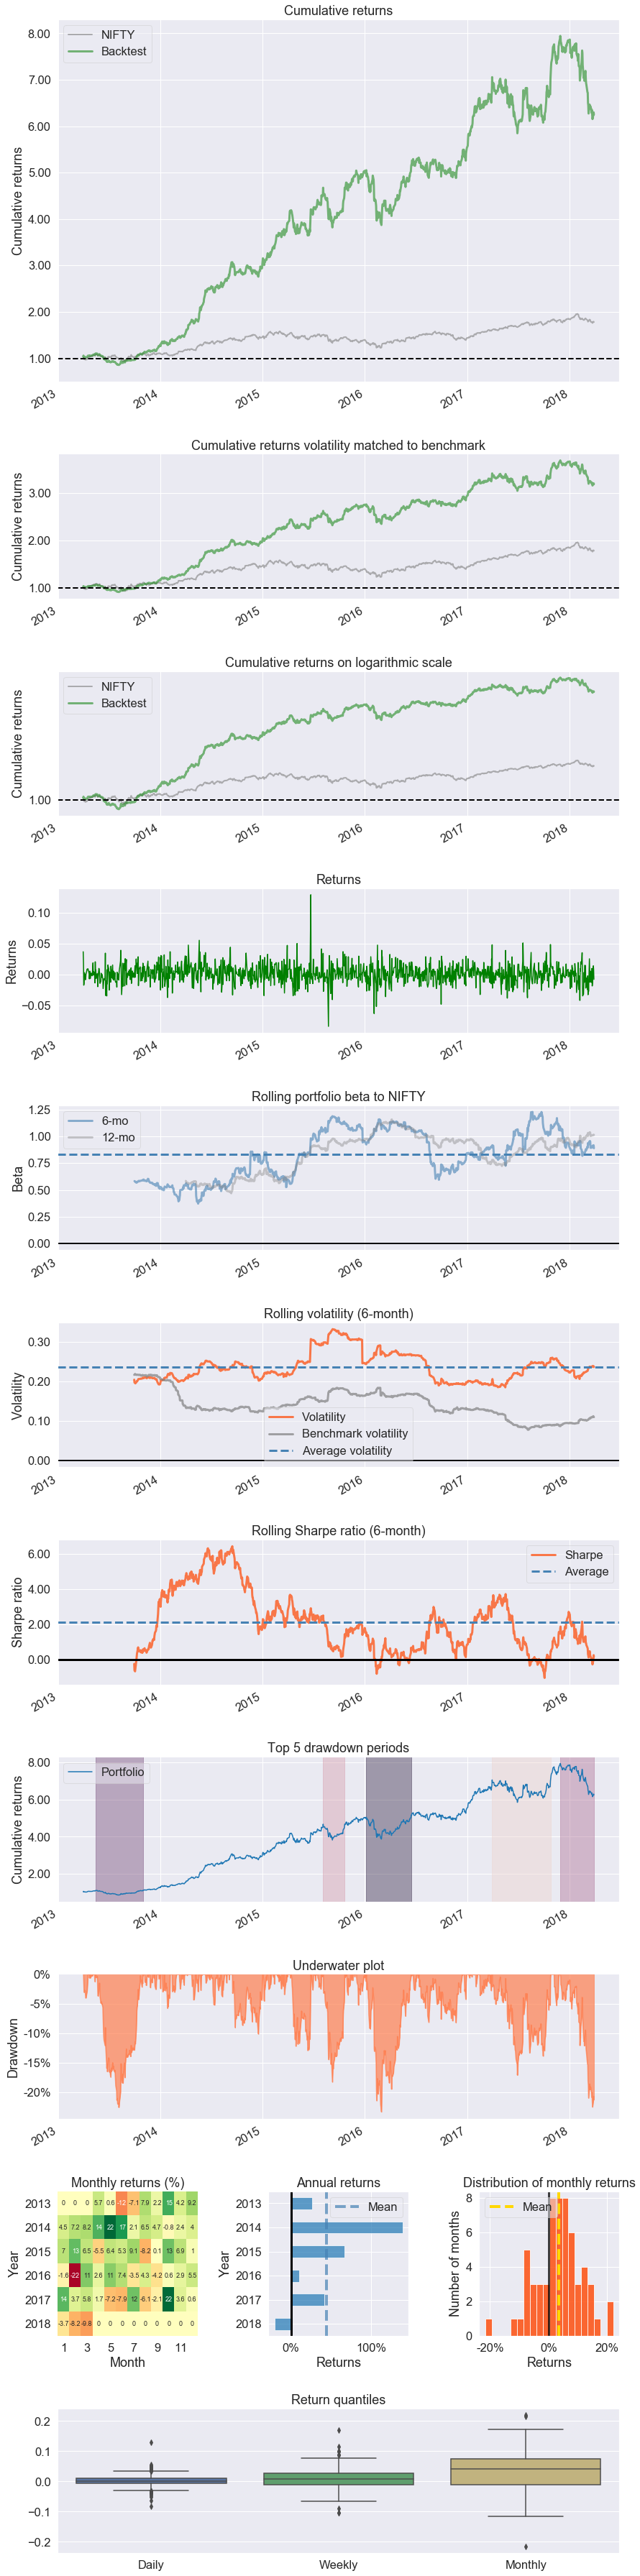

In [26]:
pf.create_returns_tear_sheet(pfReturns['2013-04-01':'2018-03-31'], 
                             benchmark_rets = indexRets['NIFTY']['2013-04-01':'2018-03-31'])